In [1]:
import os
IN_KAGGLE = 'KAGGLE_URL_BASE' in os.environ
IN_KAGGLE

True

In [2]:
if IN_KAGGLE:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value = user_secrets.get_secret("gittoken2")

    !git clone https://{secret_value}@github.com/moienr/TemporalGAN.git

Cloning into 'TemporalGAN'...
remote: Enumerating objects: 1352, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 1352 (delta 157), reused 233 (delta 129), pack-reused 1089
Receiving objects: 100% (1352/1352), 85.02 MiB | 23.39 MiB/s, done.
Resolving deltas: 100% (889/889), done.


In [3]:
if IN_KAGGLE:
    import time
    import os
    sleep_time = 5
    while not os.path.exists("/kaggle/working/TemporalGAN"):
        print("didn't find the path, wating {sleep_time} more seconds...")
        time.sleep(sleep_time)
    print("path found...")
    import sys
    sys.path.append("/kaggle/working/TemporalGAN")

path found...


In [4]:
import torch
torch.__version__

'1.13.0'

In [5]:
import numpy as np
from torch.utils.data import Dataset
from glob import glob
from skimage import io
import os
from torchvision import datasets, transforms
import matplotlib
import os
import gc
import random
os.cpu_count()

2

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [7]:
from dataset.data_loaders import *
from dataset.utils.plot_utils import plot_s1s2_tensors, save_s1s2_tensors_plot
#from config import *
from train_utils import *

In [8]:
from temporalgan.temporal_gan_v3_gen import Generator as GeneratorV3
from temporalgan.temporal_gan_v2_1_gen import Generator as GeneratorV2_1
from temporalgan.temporal_gan_v2_2_gen import Generator as GeneratorV2_2
from temporalgan.temporal_gan_v2_3_gen import Generator as GeneratorV2_3
from temporalgan.temporal_gan_v1_1_gen import Generator as GeneratorV1_1
from temporalgan.temporal_gan_v1_2_gen import Generator as GeneratorV1_2
from temporalgan.temporal_gan_v1_3_gen import Generator as GeneratorV1_3
from temporalgan.temporal_gan_v1_4_gen import Generator as GeneratorV1_4
from temporalgan.temporal_gan_v2_disc import Discriminator as DiscriminatorV2
from temporalgan.temporal_gan_v1_disc import Discriminator as DiscriminatorV1
from temporalgan.lossfunciton.loss_function import WeightedL1Loss

In [9]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [10]:
if IN_KAGGLE:
    s1_t1_dir_train= "/kaggle/input/s1s2-2021-v2/2021/s1_imgs/train"
    s2_t1_dir_train= "/kaggle/input/s1s2-2021-v2/2021/s2_imgs/train"
    s1_t2_dir_train= "/kaggle/input/s1s2-2019-v2/2019/s1_imgs/train"
    s2_t2_dir_train= "/kaggle/input/s1s2-2019-v2/2019/s2_imgs/train"
    s1_t1_dir_test = "/kaggle/input/s1s2-2021-v2/2021/s1_imgs/test"
    s2_t1_dir_test = "/kaggle/input/s1s2-2021-v2/2021/s2_imgs/test"
    s1_t2_dir_test = "/kaggle/input/s1s2-2019-v2/2019/s1_imgs/test"
    s2_t2_dir_test = "/kaggle/input/s1s2-2019-v2/2019/s2_imgs/test"
else:
    s1_t1_dir_train="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2021\\s1_imgs\\test"
    s2_t1_dir_train="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2021\\s2_imgs\\test"
    s1_t2_dir_train="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2019\\s1_imgs\\test"
    s2_t2_dir_train="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2019\\s2_imgs\\test"
    s1_t1_dir_test="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2021\\s1_imgs\\test"
    s2_t1_dir_test="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2021\\s2_imgs\\test"
    s1_t2_dir_test="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2019\\s1_imgs\\test"
    s2_t2_dir_test="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2019\\s2_imgs\\test"

In [11]:
TWO_WAY_DATASET = True if IN_KAGGLE else False
INPUT_CHANGE_MAP = True if IN_KAGGLE else False
S2_INCHANNELS = 12 if INPUT_CHANGE_MAP else 6
S1_INCHANNELS = 7 if INPUT_CHANGE_MAP else 1

LEARNING_RATE = 2e-4
BATCH_SIZE = 4 if IN_KAGGLE else 1
NUM_WORKERS = 2 if IN_KAGGLE else 8
IMAGE_SIZE = 256
WEIGHTED_LOSS = True
L1_LAMBDA = 100
NUM_EPOCHS = 10 if IN_KAGGLE else 2

LOAD_MODEL = False
SAVE_MODEL = True if IN_KAGGLE else False
SAVE_MODEL_EVERY_EPOCH = 10
SAVE_EXAMPLE_PLOTS = True
EXAMPLES_TO_PLOT = [1,32,64,128,256,512,1024] if IN_KAGGLE else [1,2]
CHECKPOINT_DISC = "disc.pth.tar"
CHECKPOINT_GEN = "gen.pth.tar"

RANDOM_SEED = 42

In [12]:
def main():
    disc = DiscriminatorV1(s2_in_channels=S2_INCHANNELS, s1_in_channels=S1_INCHANNELS).to(DEVICE)
#     gen = GeneratorV2(s2_in_channels=S2_INCHANNELS, s1_in_channels= S1_INCHANNELS, features=64,pam_downsample=2).to(DEVICE)
    gen = GeneratorV1_3(s2_in_channels=S2_INCHANNELS, s1_in_channels= S1_INCHANNELS, features=64).to(DEVICE)
#     gen = GeneratorV2_3(s2_in_channels=S2_INCHANNELS, s1_in_channels= S1_INCHANNELS, features=64).to(DEVICE)
    opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999),)
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    BCE = nn.BCEWithLogitsLoss()
    if WEIGHTED_LOSS:
        L1_LOSS = WeightedL1Loss(change_weight=5)
    else:
        L1_LOSS = nn.L1Loss()

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE,
        )

    transform = transforms.Compose([S2S1Normalize(),myToTensor(dtype=torch.float32)])


    train_dataset = Sen12Dataset(s1_t1_dir=s1_t1_dir_train,
                                 s2_t1_dir=s2_t1_dir_train,
                                 s1_t2_dir=s1_t2_dir_train,
                                 s2_t2_dir=s2_t2_dir_train,
                                 transform=transform,
                                 two_way=TWO_WAY_DATASET)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()
#     val_dataset = MapDataset(root_dir=VAL_DIR)
#     val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    for epoch in range(1, NUM_EPOCHS+1):
        print("\n\n" , end="")
        print(f"Epoch: {epoch}")
        print("")
        train_fn(
            disc, gen, train_loader, opt_disc, opt_gen,
            L1_LOSS, BCE, g_scaler, d_scaler, weighted_loss= WEIGHTED_LOSS,
            cm_input=INPUT_CHANGE_MAP, grad_clip=False)

        if SAVE_MODEL and epoch % SAVE_MODEL_EVERY_EPOCH == 0:
            save_checkpoint(epoch,gen, opt_gen, filename=CHECKPOINT_GEN)
            save_checkpoint(epoch,disc, opt_disc, filename=CHECKPOINT_DISC)


        if SAVE_EXAMPLE_PLOTS:
            for img_i in EXAMPLES_TO_PLOT:
                save_some_examples(gen, train_dataset, epoch, folder="train_evaluation_plots",cm_input=INPUT_CHANGE_MAP, img_indx=img_i)

            
        gc.collect()
        torch.cuda.empty_cache()
            
    return gen


In [13]:
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [14]:
#matplotlib.use('Agg') # This refrains matplot lib form showing the plotted resualts below the cell
gen_model = main()



Epoch: 1



100%|██████████| 663/663 [04:16<00:00,  2.59it/s, D_fake_mean=0.357, D_real_mean=0.608, G_loss_mean=12.6, L1_mean=11.3]




Epoch: 2



100%|██████████| 663/663 [04:08<00:00,  2.67it/s, D_fake_mean=0.346, D_real_mean=0.619, G_loss_mean=12.7, L1_mean=11.4]




Epoch: 3



100%|██████████| 663/663 [04:08<00:00,  2.67it/s, D_fake_mean=0.346, D_real_mean=0.611, G_loss_mean=12.7, L1_mean=11.4]




Epoch: 4



100%|██████████| 663/663 [04:08<00:00,  2.67it/s, D_fake_mean=0.351, D_real_mean=0.608, G_loss_mean=12.7, L1_mean=11.5]




Epoch: 5



100%|██████████| 663/663 [04:08<00:00,  2.67it/s, D_fake_mean=0.358, D_real_mean=0.602, G_loss_mean=12.7, L1_mean=11.5]




Epoch: 6



100%|██████████| 663/663 [04:09<00:00,  2.66it/s, D_fake_mean=0.36, D_real_mean=0.602, G_loss_mean=12.6, L1_mean=11.4] 




Epoch: 7



100%|██████████| 663/663 [04:08<00:00,  2.67it/s, D_fake_mean=0.358, D_real_mean=0.602, G_loss_mean=12.6, L1_mean=11.4]




Epoch: 8



100%|██████████| 663/663 [04:08<00:00,  2.67it/s, D_fake_mean=0.363, D_real_mean=0.599, G_loss_mean=12.6, L1_mean=11.4]




Epoch: 9



100%|██████████| 663/663 [04:08<00:00,  2.67it/s, D_fake_mean=0.368, D_real_mean=0.598, G_loss_mean=12.5, L1_mean=11.4]




Epoch: 10



100%|██████████| 663/663 [04:08<00:00,  2.67it/s, D_fake_mean=0.369, D_real_mean=0.596, G_loss_mean=12.4, L1_mean=11.3]


=> Saving checkpoint
=> Saving checkpoint


In [15]:
# transform = transforms.Compose([S2S1Normalize(),myToTensor(dtype=torch.float32)])
# train_dataset = Sen12Dataset(s1_t1_dir=s1_t1_dir_train,
#                              s2_t1_dir=s2_t1_dir_train,
#                              s1_t2_dir=s1_t2_dir_train,
#                              s2_t2_dir=s2_t2_dir_train,
#                              transform=transform,
#                              two_way=TWO_WAY_DATASET)
# #plt.imshow(train_dataset[0][-1][0])

# plt.imshow(torch.permute(train_dataset[123][4],(1,2,0))[:,:,0])
# plt.colorbar()
# plt.show()

In [16]:
transform = transforms.Compose([S2S1Normalize(),myToTensor()])
test_dataset = Sen12Dataset(s1_t1_dir=s1_t1_dir_test,
                            s2_t1_dir=s2_t1_dir_test,
                            s1_t2_dir=s1_t2_dir_test,
                            s2_t2_dir=s2_t2_dir_test,
                            transform=transform,
                            two_way=TWO_WAY_DATASET)
test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=NUM_WORKERS,
    )

In [17]:
# save_some_examples(gen_model, test_dataset, NUM_EPOCHS, folder="evaluation",cm_input=INPUT_CHANGE_MAP, img_indx=2)

In [18]:
def eval_fn(gen, loader, ssim, psnr):
    gen.eval()
    loop = tqdm(loader, leave=True)
    weighted_ssim_list = []
    normal_ssim_list = []
    weighted_psnr_list = []
    normal_psnr_list = []
    
    for idx, (s2t2,s1t2,s2t1,s1t1,cm,rcm,s1cm) in enumerate(loop):
        s2t2,s1t2,s2t1,s1t1,cm,rcm,s1cm = s2t2.to(DEVICE),s1t2.to(DEVICE),s2t1.to(DEVICE),s1t1.to(DEVICE),cm.to(DEVICE),rcm.to(DEVICE),s1cm.to(DEVICE)
        s2t2,s1t2,s2t1,s1t1,cm,rcm,s1cm = s2t2.to(torch.float32),s1t2.to(torch.float32),s2t1.to(torch.float32),s1t1.to(torch.float32),cm.to(torch.float32),rcm.to(torch.float32),s1cm.to(torch.float32)
        if INPUT_CHANGE_MAP:
            s2t2 = torch.cat((s2t2, cm), dim=1)
            s1t1 = torch.cat((s1t1, rcm), dim=1)
        preds = gen(s2t2, s1t1)
        
        weighted_ssim = ssim((s1t2, preds), s1cm)
        weighted_ssim_list.append(weighted_ssim)
        normal_ssim = ssim((s1t2, preds))
        normal_ssim_list.append(normal_ssim)
        weighted_psnr = psnr((s1t2, preds), s1cm)
        weighted_psnr_list.append(weighted_psnr)
        normal_psnr = psnr((s1t2, preds))
        normal_psnr_list.append(normal_psnr)


        if idx % 10 == 0:
            loop.set_postfix(
                wssim_mean = torch.tensor(weighted_ssim_list).mean().item(),
                ssim_mean = torch.tensor(normal_ssim_list).mean().item(),
                wpsnr_mean = torch.tensor(weighted_psnr_list).mean().item(),
                psnr_mean = torch.tensor(normal_psnr_list).mean().item(),
            )
    print("wssim_mean: " , torch.tensor(weighted_ssim_list).mean().item())
    print("ssim_mean: " , torch.tensor(normal_ssim_list).mean().item())
    print("wpsnr_mean: " , torch.tensor(weighted_psnr_list).mean().item())
    print("psnr_mean: " , torch.tensor(normal_psnr_list).mean().item())

In [19]:
from eval_metrics import ssim
from eval_metrics.psnr import wpsnr
wssim = ssim.WSSIM(data_range=1.0)

In [20]:
eval_fn(gen_model, test_loader, wssim, wpsnr)

100%|██████████| 1354/1354 [01:43<00:00, 13.12it/s, psnr_mean=16, ssim_mean=0.424, wpsnr_mean=12.5, wssim_mean=0.36]   

wssim_mean:  0.36011189222335815
ssim_mean:  0.4242304861545563
wpsnr_mean:  12.54143238067627
psnr_mean:  15.989677429199219


In [21]:
# import shutil
# shutil.rmtree("test_evaluation_plots")

In [22]:
for img_i in range(1,len(test_dataset)//2,2):
    save_some_examples(gen_model, test_dataset, NUM_EPOCHS, folder="test_evaluation_plots",cm_input=INPUT_CHANGE_MAP, img_indx=img_i)
!zip -r /kaggle/working/test_evalplot.zip  /kaggle/working/test_evaluation_plots/

  adding: kaggle/working/test_evaluation_plots/ (stored 0%)
  adding: kaggle/working/test_evaluation_plots/epoc_10_img371.png (deflated 2%)
  adding: kaggle/working/test_evaluation_plots/epoc_10_img255.png (deflated 2%)
  adding: kaggle/working/test_evaluation_plots/epoc_10_img495.png (deflated 2%)
  adding: kaggle/working/test_evaluation_plots/epoc_10_img287.png (deflated 2%)
  adding: kaggle/working/test_evaluation_plots/epoc_10_img643.png (deflated 2%)
  adding: kaggle/working/test_evaluation_plots/epoc_10_img155.png (deflated 2%)
  adding: kaggle/working/test_evaluation_plots/epoc_10_img507.png (deflated 2%)
  adding: kaggle/working/test_evaluation_plots/epoc_10_img171.png (deflated 2%)
  adding: kaggle/working/test_evaluation_plots/epoc_10_img311.png (deflated 2%)
  adding: kaggle/working/test_evaluation_plots/epoc_10_img129.png (deflated 2%)
  adding: kaggle/working/test_evaluation_plots/epoc_10_img363.png (deflated 2%)
  adding: kaggle/working/test_evaluation_plots/epoc_10_img51

In [23]:
!zip -r /kaggle/working/train_evalplot.zip  /kaggle/working/train_evaluation_plots/

  adding: kaggle/working/train_evaluation_plots/ (stored 0%)
  adding: kaggle/working/train_evaluation_plots/epoc_6_img32.png (deflated 2%)
  adding: kaggle/working/train_evaluation_plots/epoc_6_img256.png (deflated 2%)
  adding: kaggle/working/train_evaluation_plots/epoc_9_img64.png (deflated 2%)
  adding: kaggle/working/train_evaluation_plots/epoc_5_img256.png (deflated 2%)
  adding: kaggle/working/train_evaluation_plots/epoc_4_img512.png (deflated 2%)
  adding: kaggle/working/train_evaluation_plots/epoc_2_img512.png (deflated 2%)
  adding: kaggle/working/train_evaluation_plots/epoc_8_img128.png (deflated 2%)
  adding: kaggle/working/train_evaluation_plots/epoc_1_img32.png (deflated 2%)
  adding: kaggle/working/train_evaluation_plots/epoc_5_img128.png (deflated 2%)
  adding: kaggle/working/train_evaluation_plots/epoc_8_img32.png (deflated 2%)
  adding: kaggle/working/train_evaluation_plots/epoc_3_img1024.png (deflated 2%)
  adding: kaggle/working/train_evaluation_plots/epoc_3_img64.p

In [24]:
# from IPython.display import FileLink
# FileLink(r'/kaggle/working/evalplot.zip')

In [25]:
def eval_graph_fn(gen, loader, ssim, psnr):
    gen.eval()
    loop = tqdm(loader, leave=True)
    
    wssim_ratio_list = []
    wpsnr_ratio_list = []
    s1cm_mean_list   = []
    
    for idx, (s2t2,s1t2,s2t1,s1t1,cm,rcm,s1cm) in enumerate(loop):
        s2t2,s1t2,s2t1,s1t1,cm,rcm,s1cm = s2t2.to(DEVICE),s1t2.to(DEVICE),s2t1.to(DEVICE),s1t1.to(DEVICE),cm.to(DEVICE),rcm.to(DEVICE),s1cm.to(DEVICE)
        s2t2,s1t2,s2t1,s1t1,cm,rcm,s1cm = s2t2.to(torch.float32),s1t2.to(torch.float32),s2t1.to(torch.float32),s1t1.to(torch.float32),cm.to(torch.float32),rcm.to(torch.float32),s1cm.to(torch.float32)
        if INPUT_CHANGE_MAP:
            s2t2 = torch.cat((s2t2, cm), dim=1)
            s1t1 = torch.cat((s1t1, rcm), dim=1)
        preds = gen(s2t2, s1t1)
        
        s1t2_list = s1t2.to("cpu").chunk(s1t2.size(0))
        preds_list = preds.to("cpu").chunk(preds.size(0))
        s1cm_list = s1cm.to("cpu").chunk(s1cm.size(0))
        
        
        wssim_ratio_batch_list = [ssim((s1t2, preds), s1cm)/ssim((s1t2, preds)) for s1t2, preds, s1cm in zip(s1t2_list, preds_list, s1cm_list)]
        wpsnr_ratio_batch_list = [psnr((s1t2, preds), s1cm)/psnr((s1t2, preds)) for s1t2, preds, s1cm in zip(s1t2_list, preds_list, s1cm_list)]
        s1cm_mean_batch_list   = [s1cm.mean() for s1cm in s1cm_list]
        
        wssim_ratio_list = wssim_ratio_list + wssim_ratio_batch_list
        wpsnr_ratio_list = wpsnr_ratio_list + wpsnr_ratio_batch_list
        s1cm_mean_list   = s1cm_mean_list   + s1cm_mean_batch_list  
    
    return wssim_ratio_list, wpsnr_ratio_list, s1cm_mean_list

In [26]:
ssim_ratio_list, wpsnr_ratio_list, s1cm_mean_list = eval_graph_fn(gen_model, test_loader, wssim, wpsnr)

100%|██████████| 1354/1354 [01:39<00:00, 13.59it/s]


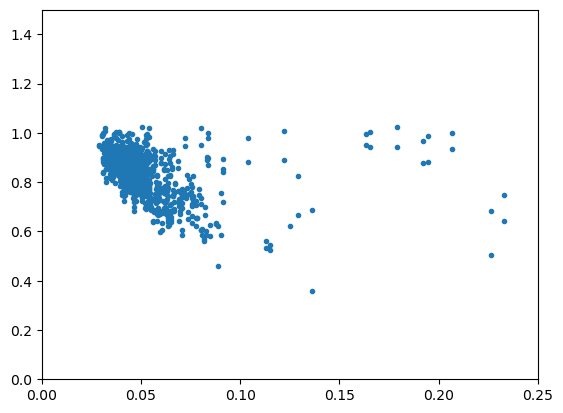

In [31]:
plt.scatter(s1cm_mean_list,ssim_ratio_list, marker = ".")
plt.ylim(0,1.5)
plt.xlim(0,0.25)
plt.show()

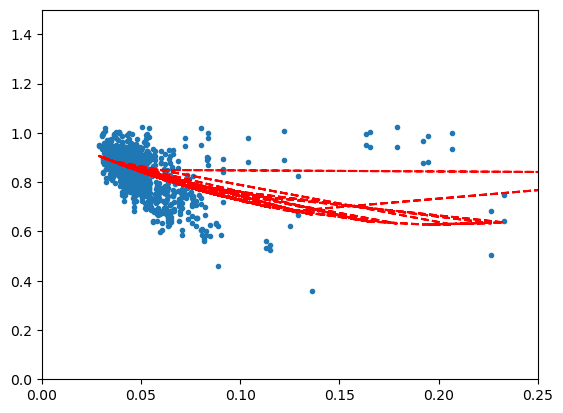

In [28]:
# Fit a polynomial trend line of degree 1
z = np.polyfit(s1cm_mean_list, ssim_ratio_list, 2)
p = np.poly1d(z)

# Plot the scatterplot and trend line
plt.scatter(s1cm_mean_list, ssim_ratio_list, marker='.')
plt.plot(s1cm_mean_list, p(s1cm_mean_list), 'r--')
plt.ylim(0, 1.5)
plt.xlim(0, 0.25)
plt.show()

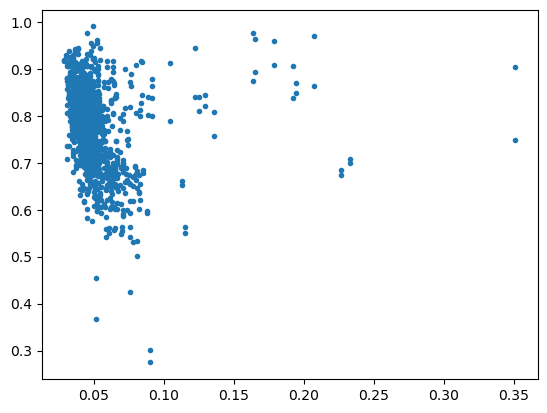

In [29]:
plt.scatter(s1cm_mean_list,wpsnr_ratio_list, marker = ".")
# plt.ylim(0.4,1)
# plt.xlim(0,0.15)
plt.show()

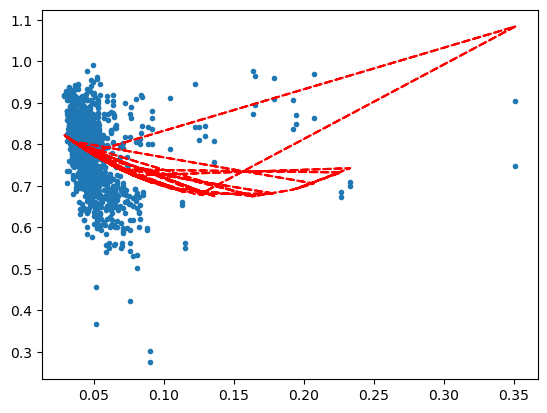

In [30]:
# Fit a polynomial trend line of degree 1
z = np.polyfit(s1cm_mean_list, wpsnr_ratio_list, 2)
p = np.poly1d(z)

# Plot the scatterplot and trend line
plt.scatter(s1cm_mean_list, wpsnr_ratio_list, marker='.')
plt.plot(s1cm_mean_list, p(s1cm_mean_list), 'r--')
# plt.ylim(1,2)
# plt.xlim(0,0.15)
plt.show()